In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAT 
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
import tqdm
import torch_geometric
import copy
# set random seed 
np.random.seed(0)
torch.manual_seed(0)

/tmp/ipykernel_14479/3023301230.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/dhakal/anaconda3/envs/GOA/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mrna = '/home/dhakal/MoBI/data/ROSMAP/mrna.csv'

In [3]:
mrna_data_ori = pd.read_csv(mrna, index_col=0)
print(mrna_data_ori['Label'].value_counts())

# train_idx = mrna_data_ori['Split'] == 1.0
# test_idx = mrna_data_ori['Split'] == 0.0
# train_idx = train_idx.reshape(-1, 1)
# test_idx = test_idx.reshape(-1, 1)
# print(train_idx.shape, test_idx.shape)
y = mrna_data_ori['Label'].values
y = torch.tensor(y,dtype = torch.int64)
print(type(y))
#drop the columns Split and label
mrna_data = mrna_data_ori.drop(columns=['Split', 'Label'])
print(mrna_data.shape)
# print(y)

Label
1.0    182
0.0    169
Name: count, dtype: int64
<class 'torch.Tensor'>
(351, 200)


In [4]:
mrna_data_ori.head()

,hsa-let-7b,hsa-let-7e,hsa-let-7f,hsa-let-7g,hsa-let-7i,hsa-miR-1,hsa-miR-9,hsa-miR-10a,hsa-miR-10b,hsa-miR-15a,...,hcmv-miR-UL70-3p,hsv1-miR-H1,hsv1-miR-H3,hsv1-miR-H8,kshv-miR-K12-2,kshv-miR-K12-4-5p,kshv-miR-K12-9,mcv-miR-M1-5p,Label,Split
1,0.814405,0.737390,0.750965,0.826721,0.732031,0.509505,0.941783,0.383358,0.237087,0.689845,...,0.269750,0.197881,0.201138,0.224232,0.225317,0.315773,0.337299,0.275999,0.0,1.0
2,0.833053,0.745852,0.784690,0.833627,0.748797,0.554802,0.939369,0.405352,0.302349,0.677308,...,0.269379,0.222585,0.247331,0.176573,0.163122,0.250090,0.365844,0.331535,1.0,1.0
3,0.783300,0.729652,0.726530,0.832673,0.718069,0.444093,0.945906,0.346858,0.272595,0.686201,...,0.315306,0.263122,0.269576,0.340817,0.252720,0.356404,0.393057,0.302595,1.0,1.0
4,0.806268,0.726243,0.737167,0.838364,0.747425,0.530010,0.951981,0.344363,0.287244,0.709395,...,0.274718,0.240122,0.210502,0.244531,0.277194,0.336700,0.344629,0.297727,0.0,1.0
5,0.803373,0.739387,0.752465,0.821804,0.715556,0.482546,0.927272,0.350344,0.243749,0.673377,...,0.270051,0.170695,0.247333,0.248524,0.217929,0.242820,0.346970,0.381820,0.0,1.0


In [5]:
train_test = mrna_data_ori['Split'].values
train_idx = train_test == 1.0
test_idx = train_test == 0.0

In [6]:
def cal_co_expression_similarity(data):
    corr_matrix = np.abs(np.corrcoef(data))
    co_expression_similarity = np.abs(corr_matrix)
    return co_expression_similarity

In [7]:
cal_co_expression_similarity(mrna_data.T).shape

(200, 200)

In [8]:
def calculate_unweighted_adjacency(expression_profiles, threshold):
    # Calculate pairwise correlation coefficients
    correlation_matrix = torch.abs(torch.corrcoef(expression_profiles))
    
    # Apply hard thresholding
    adjacency_matrix = torch.where(correlation_matrix > threshold, torch.tensor(1), torch.tensor(0))
    
    return adjacency_matrix

In [9]:
def calculate_weighted_adjacency(expression_profiles, beta):
    # Calculate pairwise correlation coefficients
    correlation_matrix = torch.corrcoef(expression_profiles)
    
    # Apply weighted transformation
    adjacency_matrix = correlation_matrix ** beta
    
    return adjacency_matrix

In [10]:
threshold = 0.2
beta = 6
mrna_data_tensor = torch.tensor(mrna_data.values.T, dtype=torch.float32)
expression_similarity = cal_co_expression_similarity(mrna_data.T)
expression_similarity = torch.tensor(expression_similarity, dtype=torch.float32)

print("Expression similarity matrix:")
print(expression_similarity.shape)

unweighted_adjacency = calculate_unweighted_adjacency(expression_similarity, threshold)
weighted_adjacency = calculate_weighted_adjacency(expression_similarity, beta)

print("Unweighted adjacency matrix:")
print(unweighted_adjacency.shape)

print("\nWeighted adjacency matrix:")
print(weighted_adjacency.shape)


# print(unweighted_adjacency.min(), unweighted_adjacency.max())

Expression similarity matrix:
torch.Size([200, 200])
Unweighted adjacency matrix:
torch.Size([200, 200])

Weighted adjacency matrix:
torch.Size([200, 200])


In [11]:
unweighted_adjacency_tensor = torch.tensor(unweighted_adjacency, dtype=torch.long)
weighted_adjacency_tensor = torch.tensor(weighted_adjacency, dtype=torch.long)
print(unweighted_adjacency_tensor.shape)
print(weighted_adjacency_tensor.shape)

edge_index_unweighted = torch.nonzero(unweighted_adjacency_tensor, as_tuple=False)
edge_index_weighted = torch.nonzero(weighted_adjacency_tensor, as_tuple=False)

print(edge_index_unweighted.shape)
print(edge_index_weighted.shape)


data_unweighted = Data(x = mrna_data_tensor.T, edge_index = edge_index_unweighted.T, y = y)
data_unweighted.train_mask = torch.tensor(train_idx, dtype=torch.bool)
data_unweighted.test_mask = torch.tensor(test_idx, dtype=torch.bool)
data_weighted = Data(x=mrna_data_tensor.T, edge_index=edge_index_weighted.T, y=y)
data_weighted.train_mask = torch.tensor(train_idx, dtype=torch.bool)
data_weighted.test_mask = torch.tensor(test_idx, dtype=torch.bool)

# print(data_unweighted)
# print(data_weighted)

torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([13004, 2])
torch.Size([162, 2])


/tmp/ipykernel_14479/3108664384.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unweighted_adjacency_tensor = torch.tensor(unweighted_adjacency, dtype=torch.long)
/tmp/ipykernel_14479/3108664384.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_adjacency_tensor = torch.tensor(weighted_adjacency, dtype=torch.long)


In [12]:
data_unweighted.train_mask

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

In [13]:
print(data_unweighted)

Data(x=[351, 200], edge_index=[2, 13004], y=[351], train_mask=[351], test_mask=[351])


In [23]:
class DataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size = 8):
        self.dataset = dataset
        self.batch_size = batch_size
        self.mask_size = self.dataset.train_mask.shape[0]
        self.train_len = sum(self.dataset.train_mask)
    
    def __len__(self):
        return self.train_len // self.batch_size
    
    def __getitem__(self,idx):
        if idx > len(self)-1:
            raise IndexError
        n_masks = self.batch_size
        true_indices = [idx*n_masks, idx*n_masks + n_masks]
        all_masks = torch.zeros(self.mask_size, dtype = torch.bool)
        all_masks[true_indices[0]:true_indices[1]] = True
        self.dataset.train_mask = all_masks & self.dataset.train_mask
        return self.dataset
        
        
        


loader = DataLoader(copy.deepcopy(data_unweighted), batch_size=16)


In [24]:
print(len(loader))
train_data = loader.__getitem__(10)
print(train_data.train_mask)
print(train_data.test_mask)

15
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, Fals

In [25]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Define the dimensions of the GNN model
input_dim = mrna_data_tensor.T.shape[1]  # Number of input features
hidden_dim = 64  # Number of hidden units
output_dim = 2  # Number of output classes

# Create an instance of the GNN model
model = GNN(input_dim, hidden_dim, output_dim)

# Move the model to the appropriate device (e.g., GPU if available)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# Print the model architecture
print(model)


GNN(
  (conv1): GCNConv(200, 64)
  (conv2): GCNConv(64, 2)
)


In [26]:
curr_data = loader.__getitem__(10)
print(curr_data.train_mask)
output = model(curr_data)
print(output.shape)

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [27]:
criterion = nn.CrossEntropyLoss()
loss = criterion(output[curr_data.train_mask], curr_data.y[curr_data.train_mask])
print(loss)

tensor(0.7652, grad_fn=<NllLossBackward0>)


In [28]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()
def train(curr_data):
    model.train()
    optimizer.zero_grad()
    output = model(curr_data)
    loss = criterion(output[curr_data.train_mask], curr_data.y[curr_data.train_mask])
    loss.backward()
    optimizer.step()

In [29]:
def test(test_data):
    model.eval()
    output = model(test_data)
    pred = output.argmax(dim=1)
    correct = pred[test_data.test_mask].eq(test_data.y[test_data.test_mask]).sum().item()
    total = test_data.test_mask.sum().item()
    return correct / total

In [30]:
test_acc = 0
pbar = tqdm.tqdm(range(200))
for epoch in pbar:  # Assuming 50 epochs
    for i  in range(len(loader)):
        curr_batch = loader.__getitem__(i)
        train(curr_batch)
        test_acc = test(curr_batch)
    pbar.set_description("Test accuracy: %.3f" % test_acc)
    print(f'Epoch: {epoch+1}, Test Acc: {test_acc:.4f}')

Test accuracy: 0.519:   0%|          | 1/200 [00:00<00:53,  3.70it/s]

Epoch: 1, Test Acc: 0.5189


Test accuracy: 0.519:   1%|          | 2/200 [00:00<00:47,  4.14it/s]

Epoch: 2, Test Acc: 0.5189


Test accuracy: 0.519:   2%|▏         | 3/200 [00:00<00:50,  3.87it/s]

Epoch: 3, Test Acc: 0.5189


Test accuracy: 0.519:   2%|▏         | 4/200 [00:01<00:52,  3.77it/s]

Epoch: 4, Test Acc: 0.5189


Test accuracy: 0.519:   2%|▎         | 5/200 [00:01<00:52,  3.72it/s]

Epoch: 5, Test Acc: 0.5189


Test accuracy: 0.519:   3%|▎         | 6/200 [00:01<00:48,  3.98it/s]

Epoch: 6, Test Acc: 0.5189


Test accuracy: 0.519:   4%|▎         | 7/200 [00:01<00:46,  4.13it/s]

Epoch: 7, Test Acc: 0.5189


Test accuracy: 0.519:   4%|▍         | 8/200 [00:02<00:45,  4.18it/s]

Epoch: 8, Test Acc: 0.5189


Test accuracy: 0.519:   4%|▍         | 9/200 [00:02<00:45,  4.22it/s]

Epoch: 9, Test Acc: 0.5189


Test accuracy: 0.519:   5%|▌         | 10/200 [00:02<00:48,  3.92it/s]

Epoch: 10, Test Acc: 0.5189


Test accuracy: 0.519:   6%|▌         | 11/200 [00:02<00:46,  4.08it/s]

Epoch: 11, Test Acc: 0.5189


Test accuracy: 0.519:   6%|▌         | 12/200 [00:03<00:45,  4.16it/s]

Epoch: 12, Test Acc: 0.5189


Test accuracy: 0.519:   6%|▋         | 13/200 [00:03<00:44,  4.25it/s]

Epoch: 13, Test Acc: 0.5189


Test accuracy: 0.519:   7%|▋         | 14/200 [00:03<00:43,  4.27it/s]

Epoch: 14, Test Acc: 0.5189


Test accuracy: 0.519:   8%|▊         | 15/200 [00:03<00:44,  4.20it/s]

Epoch: 15, Test Acc: 0.5189


Test accuracy: 0.519:   8%|▊         | 16/200 [00:04<00:42,  4.30it/s]

Epoch: 16, Test Acc: 0.5189


Test accuracy: 0.519:   8%|▊         | 17/200 [00:04<00:43,  4.23it/s]

Epoch: 17, Test Acc: 0.5189


Test accuracy: 0.519:   9%|▉         | 18/200 [00:04<00:42,  4.33it/s]

Epoch: 18, Test Acc: 0.5189


Test accuracy: 0.519:  10%|▉         | 19/200 [00:04<00:40,  4.43it/s]

Epoch: 19, Test Acc: 0.5189


Test accuracy: 0.519:  10%|█         | 20/200 [00:05<00:41,  4.31it/s]

Epoch: 20, Test Acc: 0.5189


Test accuracy: 0.519:  10%|█         | 21/200 [00:05<00:41,  4.30it/s]

Epoch: 21, Test Acc: 0.5189


Test accuracy: 0.519:  11%|█         | 22/200 [00:05<00:40,  4.39it/s]

Epoch: 22, Test Acc: 0.5189


Test accuracy: 0.519:  12%|█▏        | 23/200 [00:05<00:39,  4.43it/s]

Epoch: 23, Test Acc: 0.5189


Test accuracy: 0.519:  12%|█▏        | 24/200 [00:05<00:39,  4.48it/s]

Epoch: 24, Test Acc: 0.5189


Test accuracy: 0.519:  12%|█▎        | 25/200 [00:06<00:38,  4.52it/s]

Epoch: 25, Test Acc: 0.5189


Test accuracy: 0.519:  13%|█▎        | 26/200 [00:06<00:38,  4.58it/s]

Epoch: 26, Test Acc: 0.5189


Test accuracy: 0.519:  14%|█▎        | 27/200 [00:06<00:41,  4.19it/s]

Epoch: 27, Test Acc: 0.5189


Test accuracy: 0.519:  14%|█▍        | 28/200 [00:06<00:40,  4.28it/s]

Epoch: 28, Test Acc: 0.5189


Test accuracy: 0.519:  14%|█▍        | 29/200 [00:07<00:39,  4.33it/s]

Epoch: 29, Test Acc: 0.5189


Test accuracy: 0.519:  15%|█▌        | 30/200 [00:07<00:41,  4.09it/s]

Epoch: 30, Test Acc: 0.5189


Test accuracy: 0.519:  16%|█▌        | 31/200 [00:07<00:40,  4.16it/s]

Epoch: 31, Test Acc: 0.5189


Test accuracy: 0.519:  16%|█▌        | 32/200 [00:07<00:41,  4.04it/s]

Epoch: 32, Test Acc: 0.5189


Test accuracy: 0.519:  16%|█▋        | 33/200 [00:08<00:40,  4.17it/s]

Epoch: 33, Test Acc: 0.5189


Test accuracy: 0.519:  17%|█▋        | 34/200 [00:08<00:39,  4.18it/s]

Epoch: 34, Test Acc: 0.5189


Test accuracy: 0.519:  18%|█▊        | 35/200 [00:08<00:39,  4.13it/s]

Epoch: 35, Test Acc: 0.5189


Test accuracy: 0.519:  18%|█▊        | 36/200 [00:08<00:38,  4.23it/s]

Epoch: 36, Test Acc: 0.5189


Test accuracy: 0.519:  18%|█▊        | 37/200 [00:09<00:39,  4.14it/s]

Epoch: 37, Test Acc: 0.5189


Test accuracy: 0.519:  19%|█▉        | 38/200 [00:09<00:38,  4.23it/s]

Epoch: 38, Test Acc: 0.5189


Test accuracy: 0.519:  20%|█▉        | 39/200 [00:09<00:40,  3.99it/s]

Epoch: 39, Test Acc: 0.5189


Test accuracy: 0.519:  20%|██        | 40/200 [00:09<00:41,  3.82it/s]

Epoch: 40, Test Acc: 0.5189


Test accuracy: 0.519:  20%|██        | 41/200 [00:10<00:43,  3.66it/s]

Epoch: 41, Test Acc: 0.5189


Test accuracy: 0.519:  21%|██        | 42/200 [00:10<00:44,  3.59it/s]

Epoch: 42, Test Acc: 0.5189


Test accuracy: 0.519:  22%|██▏       | 43/200 [00:10<00:44,  3.54it/s]

Epoch: 43, Test Acc: 0.5189


Test accuracy: 0.519:  22%|██▏       | 44/200 [00:10<00:42,  3.65it/s]

Epoch: 44, Test Acc: 0.5189


Test accuracy: 0.519:  22%|██▎       | 45/200 [00:11<00:40,  3.80it/s]

Epoch: 45, Test Acc: 0.5189


Test accuracy: 0.519:  23%|██▎       | 46/200 [00:11<00:38,  3.97it/s]

Epoch: 46, Test Acc: 0.5189


Test accuracy: 0.519:  24%|██▎       | 47/200 [00:11<00:37,  4.04it/s]

Epoch: 47, Test Acc: 0.5189


Test accuracy: 0.519:  24%|██▍       | 48/200 [00:11<00:37,  4.11it/s]

Epoch: 48, Test Acc: 0.5189


Test accuracy: 0.519:  24%|██▍       | 49/200 [00:12<00:36,  4.14it/s]

Epoch: 49, Test Acc: 0.5189


Test accuracy: 0.519:  25%|██▌       | 50/200 [00:12<00:36,  4.14it/s]

Epoch: 50, Test Acc: 0.5189


Test accuracy: 0.519:  26%|██▌       | 51/200 [00:12<00:35,  4.17it/s]

Epoch: 51, Test Acc: 0.5189


Test accuracy: 0.519:  26%|██▌       | 52/200 [00:12<00:35,  4.22it/s]

Epoch: 52, Test Acc: 0.5189


Test accuracy: 0.519:  26%|██▋       | 53/200 [00:13<00:34,  4.27it/s]

Epoch: 53, Test Acc: 0.5189


Test accuracy: 0.519:  27%|██▋       | 54/200 [00:13<00:33,  4.31it/s]

Epoch: 54, Test Acc: 0.5189


Test accuracy: 0.519:  28%|██▊       | 55/200 [00:13<00:33,  4.34it/s]

Epoch: 55, Test Acc: 0.5189


Test accuracy: 0.519:  28%|██▊       | 56/200 [00:13<00:33,  4.31it/s]

Epoch: 56, Test Acc: 0.5189


Test accuracy: 0.519:  28%|██▊       | 57/200 [00:13<00:33,  4.32it/s]

Epoch: 57, Test Acc: 0.5189


Test accuracy: 0.519:  29%|██▉       | 58/200 [00:14<00:33,  4.30it/s]

Epoch: 58, Test Acc: 0.5189


Test accuracy: 0.519:  30%|██▉       | 59/200 [00:14<00:32,  4.29it/s]

Epoch: 59, Test Acc: 0.5189


Test accuracy: 0.519:  30%|███       | 60/200 [00:14<00:33,  4.14it/s]

Epoch: 60, Test Acc: 0.5189


Test accuracy: 0.519:  30%|███       | 61/200 [00:14<00:33,  4.15it/s]

Epoch: 61, Test Acc: 0.5189


Test accuracy: 0.519:  31%|███       | 62/200 [00:15<00:33,  4.13it/s]

Epoch: 62, Test Acc: 0.5189


Test accuracy: 0.519:  32%|███▏      | 63/200 [00:15<00:32,  4.24it/s]

Epoch: 63, Test Acc: 0.5189


Test accuracy: 0.519:  32%|███▏      | 64/200 [00:15<00:31,  4.28it/s]

Epoch: 64, Test Acc: 0.5189


Test accuracy: 0.519:  32%|███▎      | 65/200 [00:15<00:30,  4.38it/s]

Epoch: 65, Test Acc: 0.5189


Test accuracy: 0.519:  33%|███▎      | 66/200 [00:16<00:30,  4.40it/s]

Epoch: 66, Test Acc: 0.5189


Test accuracy: 0.519:  34%|███▎      | 67/200 [00:16<00:29,  4.46it/s]

Epoch: 67, Test Acc: 0.5189


Test accuracy: 0.519:  34%|███▍      | 68/200 [00:16<00:29,  4.50it/s]

Epoch: 68, Test Acc: 0.5189


Test accuracy: 0.519:  34%|███▍      | 69/200 [00:16<00:29,  4.47it/s]

Epoch: 69, Test Acc: 0.5189


Test accuracy: 0.519:  35%|███▌      | 70/200 [00:16<00:28,  4.54it/s]

Epoch: 70, Test Acc: 0.5189


Test accuracy: 0.519:  36%|███▌      | 71/200 [00:17<00:28,  4.54it/s]

Epoch: 71, Test Acc: 0.5189


Test accuracy: 0.519:  36%|███▌      | 72/200 [00:17<00:28,  4.53it/s]

Epoch: 72, Test Acc: 0.5189


Test accuracy: 0.519:  36%|███▋      | 73/200 [00:17<00:27,  4.55it/s]

Epoch: 73, Test Acc: 0.5189


Test accuracy: 0.519:  37%|███▋      | 74/200 [00:17<00:27,  4.52it/s]

Epoch: 74, Test Acc: 0.5189


Test accuracy: 0.519:  38%|███▊      | 75/200 [00:18<00:27,  4.57it/s]

Epoch: 75, Test Acc: 0.5189


Test accuracy: 0.519:  38%|███▊      | 76/200 [00:18<00:26,  4.59it/s]

Epoch: 76, Test Acc: 0.5189


Test accuracy: 0.519:  38%|███▊      | 77/200 [00:18<00:26,  4.62it/s]

Epoch: 77, Test Acc: 0.5189


Test accuracy: 0.519:  39%|███▉      | 78/200 [00:18<00:26,  4.57it/s]

Epoch: 78, Test Acc: 0.5189


Test accuracy: 0.519:  40%|███▉      | 79/200 [00:18<00:26,  4.59it/s]

Epoch: 79, Test Acc: 0.5189


Test accuracy: 0.519:  40%|████      | 80/200 [00:19<00:26,  4.60it/s]

Epoch: 80, Test Acc: 0.5189


Test accuracy: 0.519:  40%|████      | 81/200 [00:19<00:25,  4.61it/s]

Epoch: 81, Test Acc: 0.5189


Test accuracy: 0.519:  41%|████      | 82/200 [00:19<00:25,  4.58it/s]

Epoch: 82, Test Acc: 0.5189


Test accuracy: 0.519:  42%|████▏     | 83/200 [00:19<00:25,  4.59it/s]

Epoch: 83, Test Acc: 0.5189


Test accuracy: 0.519:  42%|████▏     | 84/200 [00:20<00:25,  4.57it/s]

Epoch: 84, Test Acc: 0.5189


Test accuracy: 0.519:  42%|████▎     | 85/200 [00:20<00:25,  4.51it/s]

Epoch: 85, Test Acc: 0.5189


Test accuracy: 0.519:  43%|████▎     | 86/200 [00:20<00:25,  4.43it/s]

Epoch: 86, Test Acc: 0.5189


Test accuracy: 0.519:  44%|████▎     | 87/200 [00:20<00:25,  4.50it/s]

Epoch: 87, Test Acc: 0.5189


Test accuracy: 0.519:  44%|████▍     | 88/200 [00:20<00:26,  4.21it/s]

Epoch: 88, Test Acc: 0.5189


Test accuracy: 0.519:  44%|████▍     | 89/200 [00:21<00:25,  4.28it/s]

Epoch: 89, Test Acc: 0.5189


Test accuracy: 0.519:  45%|████▌     | 90/200 [00:21<00:24,  4.40it/s]

Epoch: 90, Test Acc: 0.5189


Test accuracy: 0.519:  46%|████▌     | 91/200 [00:21<00:24,  4.49it/s]

Epoch: 91, Test Acc: 0.5189


Test accuracy: 0.519:  46%|████▌     | 92/200 [00:21<00:23,  4.55it/s]

Epoch: 92, Test Acc: 0.5189


Test accuracy: 0.519:  46%|████▋     | 93/200 [00:22<00:23,  4.58it/s]

Epoch: 93, Test Acc: 0.5189


Test accuracy: 0.519:  47%|████▋     | 94/200 [00:22<00:23,  4.54it/s]

Epoch: 94, Test Acc: 0.5189


Test accuracy: 0.519:  48%|████▊     | 95/200 [00:22<00:23,  4.54it/s]

Epoch: 95, Test Acc: 0.5189


Test accuracy: 0.519:  48%|████▊     | 96/200 [00:22<00:23,  4.50it/s]

Epoch: 96, Test Acc: 0.5189


Test accuracy: 0.519:  48%|████▊     | 97/200 [00:22<00:22,  4.52it/s]

Epoch: 97, Test Acc: 0.5189


Test accuracy: 0.519:  49%|████▉     | 98/200 [00:23<00:22,  4.57it/s]

Epoch: 98, Test Acc: 0.5189


Test accuracy: 0.519:  50%|████▉     | 99/200 [00:23<00:22,  4.54it/s]

Epoch: 99, Test Acc: 0.5189


Test accuracy: 0.519:  50%|█████     | 100/200 [00:23<00:21,  4.56it/s]

Epoch: 100, Test Acc: 0.5189


Test accuracy: 0.519:  50%|█████     | 101/200 [00:23<00:21,  4.57it/s]

Epoch: 101, Test Acc: 0.5189


Test accuracy: 0.519:  51%|█████     | 102/200 [00:24<00:21,  4.57it/s]

Epoch: 102, Test Acc: 0.5189


Test accuracy: 0.519:  52%|█████▏    | 103/200 [00:24<00:21,  4.44it/s]

Epoch: 103, Test Acc: 0.5189


Test accuracy: 0.519:  52%|█████▏    | 104/200 [00:24<00:21,  4.47it/s]

Epoch: 104, Test Acc: 0.5189


Test accuracy: 0.519:  52%|█████▎    | 105/200 [00:24<00:20,  4.53it/s]

Epoch: 105, Test Acc: 0.5189


Test accuracy: 0.519:  53%|█████▎    | 106/200 [00:24<00:20,  4.58it/s]

Epoch: 106, Test Acc: 0.5189


Test accuracy: 0.519:  54%|█████▎    | 107/200 [00:25<00:20,  4.56it/s]

Epoch: 107, Test Acc: 0.5189


Test accuracy: 0.519:  54%|█████▍    | 108/200 [00:25<00:20,  4.58it/s]

Epoch: 108, Test Acc: 0.5189


Test accuracy: 0.519:  55%|█████▍    | 109/200 [00:25<00:19,  4.58it/s]

Epoch: 109, Test Acc: 0.5189


Test accuracy: 0.519:  55%|█████▌    | 110/200 [00:25<00:19,  4.57it/s]

Epoch: 110, Test Acc: 0.5189


Test accuracy: 0.519:  56%|█████▌    | 111/200 [00:25<00:19,  4.62it/s]

Epoch: 111, Test Acc: 0.5189


Test accuracy: 0.519:  56%|█████▌    | 112/200 [00:26<00:19,  4.60it/s]

Epoch: 112, Test Acc: 0.5189


Test accuracy: 0.519:  56%|█████▋    | 113/200 [00:26<00:18,  4.61it/s]

Epoch: 113, Test Acc: 0.5189


Test accuracy: 0.519:  57%|█████▋    | 114/200 [00:26<00:18,  4.63it/s]

Epoch: 114, Test Acc: 0.5189


Test accuracy: 0.519:  57%|█████▊    | 115/200 [00:26<00:18,  4.60it/s]

Epoch: 115, Test Acc: 0.5189


Test accuracy: 0.519:  58%|█████▊    | 116/200 [00:27<00:18,  4.63it/s]

Epoch: 116, Test Acc: 0.5189


Test accuracy: 0.519:  58%|█████▊    | 117/200 [00:27<00:17,  4.63it/s]

Epoch: 117, Test Acc: 0.5189


Test accuracy: 0.519:  59%|█████▉    | 118/200 [00:27<00:17,  4.59it/s]

Epoch: 118, Test Acc: 0.5189


Test accuracy: 0.519:  60%|█████▉    | 119/200 [00:27<00:17,  4.56it/s]

Epoch: 119, Test Acc: 0.5189


Test accuracy: 0.519:  60%|██████    | 120/200 [00:27<00:17,  4.49it/s]

Epoch: 120, Test Acc: 0.5189


Test accuracy: 0.519:  60%|██████    | 121/200 [00:28<00:18,  4.37it/s]

Epoch: 121, Test Acc: 0.5189


Test accuracy: 0.519:  61%|██████    | 122/200 [00:28<00:17,  4.34it/s]

Epoch: 122, Test Acc: 0.5189


Test accuracy: 0.519:  62%|██████▏   | 123/200 [00:28<00:17,  4.30it/s]

Epoch: 123, Test Acc: 0.5189


Test accuracy: 0.519:  62%|██████▏   | 124/200 [00:28<00:17,  4.29it/s]

Epoch: 124, Test Acc: 0.5189


Test accuracy: 0.519:  62%|██████▎   | 125/200 [00:29<00:17,  4.33it/s]

Epoch: 125, Test Acc: 0.5189


Test accuracy: 0.519:  63%|██████▎   | 126/200 [00:29<00:16,  4.44it/s]

Epoch: 126, Test Acc: 0.5189


Test accuracy: 0.519:  64%|██████▎   | 127/200 [00:29<00:16,  4.47it/s]

Epoch: 127, Test Acc: 0.5189


Test accuracy: 0.519:  64%|██████▍   | 128/200 [00:29<00:16,  4.48it/s]

Epoch: 128, Test Acc: 0.5189


Test accuracy: 0.519:  64%|██████▍   | 129/200 [00:30<00:15,  4.44it/s]

Epoch: 129, Test Acc: 0.5189


Test accuracy: 0.519:  65%|██████▌   | 130/200 [00:30<00:15,  4.50it/s]

Epoch: 130, Test Acc: 0.5189


Test accuracy: 0.519:  66%|██████▌   | 131/200 [00:30<00:15,  4.50it/s]

Epoch: 131, Test Acc: 0.5189


Test accuracy: 0.519:  66%|██████▌   | 132/200 [00:30<00:15,  4.50it/s]

Epoch: 132, Test Acc: 0.5189


Test accuracy: 0.519:  66%|██████▋   | 133/200 [00:30<00:15,  4.31it/s]

Epoch: 133, Test Acc: 0.5189


Test accuracy: 0.519:  67%|██████▋   | 134/200 [00:31<00:15,  4.35it/s]

Epoch: 134, Test Acc: 0.5189


Test accuracy: 0.519:  68%|██████▊   | 135/200 [00:31<00:15,  4.22it/s]

Epoch: 135, Test Acc: 0.5189


Test accuracy: 0.519:  68%|██████▊   | 136/200 [00:31<00:16,  3.99it/s]

Epoch: 136, Test Acc: 0.5189


Test accuracy: 0.519:  68%|██████▊   | 137/200 [00:31<00:15,  4.10it/s]

Epoch: 137, Test Acc: 0.5189


Test accuracy: 0.519:  69%|██████▉   | 138/200 [00:32<00:14,  4.20it/s]

Epoch: 138, Test Acc: 0.5189


Test accuracy: 0.519:  70%|██████▉   | 139/200 [00:32<00:14,  4.20it/s]

Epoch: 139, Test Acc: 0.5189


Test accuracy: 0.519:  70%|███████   | 140/200 [00:32<00:14,  4.12it/s]

Epoch: 140, Test Acc: 0.5189


Test accuracy: 0.519:  70%|███████   | 141/200 [00:32<00:13,  4.24it/s]

Epoch: 141, Test Acc: 0.5189


Test accuracy: 0.519:  71%|███████   | 142/200 [00:33<00:13,  4.31it/s]

Epoch: 142, Test Acc: 0.5189


Test accuracy: 0.519:  72%|███████▏  | 143/200 [00:33<00:12,  4.39it/s]

Epoch: 143, Test Acc: 0.5189


Test accuracy: 0.519:  72%|███████▏  | 144/200 [00:33<00:12,  4.45it/s]

Epoch: 144, Test Acc: 0.5189


Test accuracy: 0.519:  72%|███████▎  | 145/200 [00:33<00:12,  4.47it/s]

Epoch: 145, Test Acc: 0.5189


Test accuracy: 0.519:  73%|███████▎  | 146/200 [00:33<00:12,  4.48it/s]

Epoch: 146, Test Acc: 0.5189


Test accuracy: 0.519:  74%|███████▎  | 147/200 [00:34<00:11,  4.49it/s]

Epoch: 147, Test Acc: 0.5189


Test accuracy: 0.519:  74%|███████▍  | 148/200 [00:34<00:11,  4.52it/s]

Epoch: 148, Test Acc: 0.5189


Test accuracy: 0.519:  74%|███████▍  | 149/200 [00:34<00:11,  4.47it/s]

Epoch: 149, Test Acc: 0.5189


Test accuracy: 0.519:  75%|███████▌  | 150/200 [00:34<00:11,  4.51it/s]

Epoch: 150, Test Acc: 0.5189


Test accuracy: 0.519:  76%|███████▌  | 151/200 [00:35<00:10,  4.48it/s]

Epoch: 151, Test Acc: 0.5189


Test accuracy: 0.519:  76%|███████▌  | 152/200 [00:35<00:10,  4.46it/s]

Epoch: 152, Test Acc: 0.5189


Test accuracy: 0.519:  76%|███████▋  | 153/200 [00:35<00:10,  4.47it/s]

Epoch: 153, Test Acc: 0.5189


Test accuracy: 0.519:  77%|███████▋  | 154/200 [00:35<00:10,  4.47it/s]

Epoch: 154, Test Acc: 0.5189


Test accuracy: 0.519:  78%|███████▊  | 155/200 [00:35<00:09,  4.51it/s]

Epoch: 155, Test Acc: 0.5189


Test accuracy: 0.519:  78%|███████▊  | 156/200 [00:36<00:09,  4.54it/s]

Epoch: 156, Test Acc: 0.5189


Test accuracy: 0.519:  78%|███████▊  | 157/200 [00:36<00:09,  4.51it/s]

Epoch: 157, Test Acc: 0.5189


Test accuracy: 0.519:  79%|███████▉  | 158/200 [00:36<00:09,  4.39it/s]

Epoch: 158, Test Acc: 0.5189


Test accuracy: 0.519:  80%|███████▉  | 159/200 [00:36<00:09,  4.28it/s]

Epoch: 159, Test Acc: 0.5189


Test accuracy: 0.519:  80%|████████  | 160/200 [00:37<00:09,  4.36it/s]

Epoch: 160, Test Acc: 0.5189


Test accuracy: 0.519:  80%|████████  | 161/200 [00:37<00:09,  4.28it/s]

Epoch: 161, Test Acc: 0.5189


Test accuracy: 0.519:  81%|████████  | 162/200 [00:37<00:08,  4.37it/s]

Epoch: 162, Test Acc: 0.5189


Test accuracy: 0.519:  82%|████████▏ | 163/200 [00:37<00:08,  4.35it/s]

Epoch: 163, Test Acc: 0.5189


Test accuracy: 0.519:  82%|████████▏ | 164/200 [00:38<00:08,  4.11it/s]

Epoch: 164, Test Acc: 0.5189


Test accuracy: 0.519:  82%|████████▎ | 165/200 [00:38<00:08,  3.95it/s]

Epoch: 165, Test Acc: 0.5189


Test accuracy: 0.519:  83%|████████▎ | 166/200 [00:38<00:09,  3.74it/s]

Epoch: 166, Test Acc: 0.5189


Test accuracy: 0.519:  84%|████████▎ | 167/200 [00:38<00:09,  3.55it/s]

Epoch: 167, Test Acc: 0.5189


Test accuracy: 0.519:  84%|████████▍ | 168/200 [00:39<00:08,  3.68it/s]

Epoch: 168, Test Acc: 0.5189


Test accuracy: 0.519:  84%|████████▍ | 169/200 [00:39<00:07,  3.92it/s]

Epoch: 169, Test Acc: 0.5189


Test accuracy: 0.519:  85%|████████▌ | 170/200 [00:39<00:07,  4.01it/s]

Epoch: 170, Test Acc: 0.5189


Test accuracy: 0.519:  86%|████████▌ | 171/200 [00:39<00:06,  4.16it/s]

Epoch: 171, Test Acc: 0.5189


Test accuracy: 0.519:  86%|████████▌ | 172/200 [00:40<00:07,  3.81it/s]

Epoch: 172, Test Acc: 0.5189


Test accuracy: 0.519:  86%|████████▋ | 173/200 [00:40<00:07,  3.81it/s]

Epoch: 173, Test Acc: 0.5189


Test accuracy: 0.519:  87%|████████▋ | 174/200 [00:40<00:06,  3.77it/s]

Epoch: 174, Test Acc: 0.5189


Test accuracy: 0.519:  88%|████████▊ | 175/200 [00:40<00:06,  3.94it/s]

Epoch: 175, Test Acc: 0.5189


Test accuracy: 0.519:  88%|████████▊ | 176/200 [00:41<00:05,  4.05it/s]

Epoch: 176, Test Acc: 0.5189


Test accuracy: 0.519:  88%|████████▊ | 177/200 [00:41<00:05,  4.12it/s]

Epoch: 177, Test Acc: 0.5189


Test accuracy: 0.519:  89%|████████▉ | 178/200 [00:41<00:05,  4.17it/s]

Epoch: 178, Test Acc: 0.5189


Test accuracy: 0.519:  90%|████████▉ | 179/200 [00:41<00:04,  4.23it/s]

Epoch: 179, Test Acc: 0.5189


Test accuracy: 0.519:  90%|█████████ | 180/200 [00:42<00:04,  4.27it/s]

Epoch: 180, Test Acc: 0.5189


Test accuracy: 0.519:  90%|█████████ | 181/200 [00:42<00:04,  4.34it/s]

Epoch: 181, Test Acc: 0.5189


Test accuracy: 0.519:  91%|█████████ | 182/200 [00:42<00:04,  4.34it/s]

Epoch: 182, Test Acc: 0.5189


Test accuracy: 0.519:  92%|█████████▏| 183/200 [00:42<00:04,  4.10it/s]

Epoch: 183, Test Acc: 0.5189


Test accuracy: 0.519:  92%|█████████▏| 184/200 [00:43<00:03,  4.24it/s]

Epoch: 184, Test Acc: 0.5189


Test accuracy: 0.519:  92%|█████████▎| 185/200 [00:43<00:03,  4.14it/s]

Epoch: 185, Test Acc: 0.5189


Test accuracy: 0.519:  93%|█████████▎| 186/200 [00:43<00:03,  4.16it/s]

Epoch: 186, Test Acc: 0.5189


Test accuracy: 0.519:  94%|█████████▎| 187/200 [00:43<00:03,  4.24it/s]

Epoch: 187, Test Acc: 0.5189


Test accuracy: 0.519:  94%|█████████▍| 188/200 [00:44<00:02,  4.28it/s]

Epoch: 188, Test Acc: 0.5189


Test accuracy: 0.519:  94%|█████████▍| 189/200 [00:44<00:02,  4.32it/s]

Epoch: 189, Test Acc: 0.5189


Test accuracy: 0.519:  95%|█████████▌| 190/200 [00:44<00:02,  4.19it/s]

Epoch: 190, Test Acc: 0.5189


Test accuracy: 0.519:  96%|█████████▌| 191/200 [00:44<00:02,  4.23it/s]

Epoch: 191, Test Acc: 0.5189


Test accuracy: 0.519:  96%|█████████▌| 192/200 [00:45<00:01,  4.12it/s]

Epoch: 192, Test Acc: 0.5189


Test accuracy: 0.519:  96%|█████████▋| 193/200 [00:45<00:01,  4.06it/s]

Epoch: 193, Test Acc: 0.5189


Test accuracy: 0.519:  97%|█████████▋| 194/200 [00:45<00:01,  4.21it/s]

Epoch: 194, Test Acc: 0.5189


Test accuracy: 0.519:  98%|█████████▊| 195/200 [00:45<00:01,  4.26it/s]

Epoch: 195, Test Acc: 0.5189


Test accuracy: 0.519:  98%|█████████▊| 196/200 [00:45<00:00,  4.38it/s]

Epoch: 196, Test Acc: 0.5189


Test accuracy: 0.519:  98%|█████████▊| 197/200 [00:46<00:00,  4.42it/s]

Epoch: 197, Test Acc: 0.5189


Test accuracy: 0.519:  99%|█████████▉| 198/200 [00:46<00:00,  4.49it/s]

Epoch: 198, Test Acc: 0.5189


Test accuracy: 0.519: 100%|█████████▉| 199/200 [00:46<00:00,  4.51it/s]

Epoch: 199, Test Acc: 0.5189


Test accuracy: 0.519: 100%|██████████| 200/200 [00:46<00:00,  4.29it/s]

Epoch: 200, Test Acc: 0.5189


In [31]:
test_acc = test(data_unweighted)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5189


In [32]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

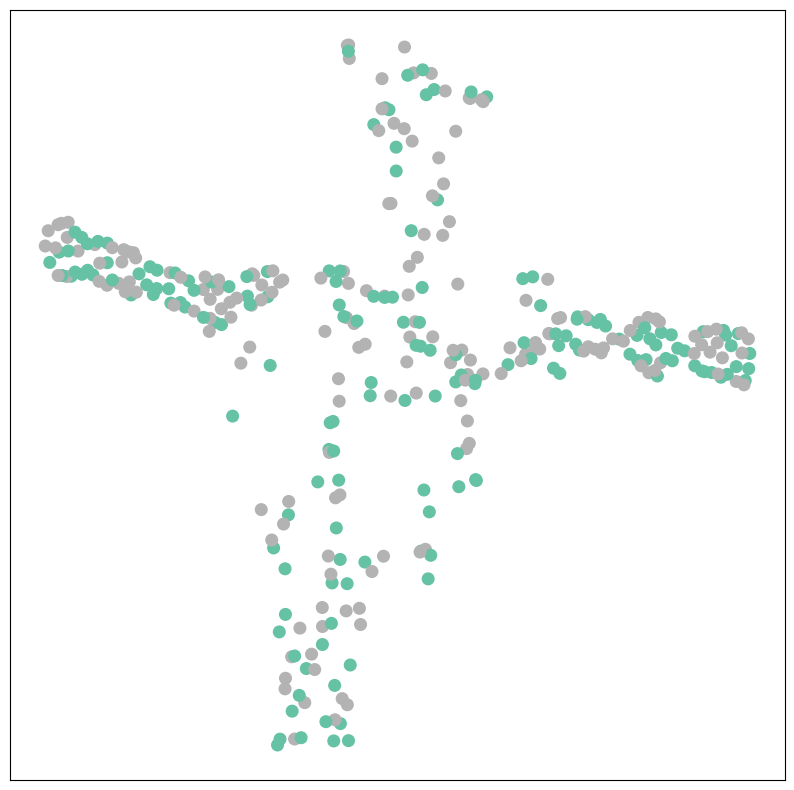

In [33]:
out = model(data_unweighted)
visualize(out, color=data_unweighted.y)